In [1]:
# Installing packages
! pip install bertopic
! pip install transformers
! pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00


In [2]:
## Importing
import pandas as pd
from bertopic import BERTopic
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [3]:
path_data = "/content/New Data set 1.xls"
df = pd.read_excel(path_data)
df = df.dropna()
# بررسی وجود NaN پس از عملیات dropna
if df.isnull().sum().sum() == 0:
    print("هیچ مقدار NaN در دیتاست وجود ندارد.")
else:
    print("هنوز مقادیر NaN در دیتاست وجود دارند.")

هیچ مقدار NaN در دیتاست وجود ندارد.


In [4]:
# حذف مقادیر تکراری
df = df.drop_duplicates()

In [5]:
## Display the first 5 rows of data
print(df.head(5))

                                     Authors  \
0              Liang, W; Zhang, L; Kadoch, M   
1                    Ma Z.; Yang X.; Miao R.   
2      Abbas, K; Afaq, M; Khan, TA; Song, WC   
3  Jesse F.F.; Antonini C.; Luque-Vilchez M.   
4     Charles, V; Emrouznejad, A; Gherman, T   

                                               Title  \
0  6G IoT Tracking- and Machine Learning-Enhanced...   
1  A Big Data-Driven Risk Assessment Method Using...   
2  A Blockchain and Machine Learning-Based Drug S...   
3  A circularity accounting network: CO2 measurem...   
4  A critical analysis of the integration of bloc...   

                                        Source Title Document Type  \
0                                        ELECTRONICS       Article   
1         Journal of Circuits, Systems and Computers       Article   
2                                        ELECTRONICS       Article   
3  Revista de Contabilidad-Spanish Accounting Review       Article   
4                      A

In [6]:
# تبدیل ستون‌ها به رشته و ترکیب عنوان، چکیده و کلیدواژه‌ها
df['text'] = df['Title'].astype("str") + " " + df['Abstract'].astype("str") + " " + df['Keywords'].astype("str")

# حذف ردیف‌هایی که مقدار نال دارند
df = df.dropna(subset=['text'])

In [7]:
print(df['text'].head())

0    6G IoT Tracking- and Machine Learning-Enhanced...
1    A Big Data-Driven Risk Assessment Method Using...
2    A Blockchain and Machine Learning-Based Drug S...
3    A circularity accounting network: CO2 measurem...
4    A critical analysis of the integration of bloc...
Name: text, dtype: object


## PreProcessing dataset

In [8]:
import re
from tqdm import tqdm
#library that contains punctuation
import string
# print(string.punctuation)
#importing nlp library
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from collections import Counter
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [38]:
### Level One for Preprocessing
## Punctuation Removal
def clean_text(text):
    if isinstance(text, str):
        return " ".join(text.split())  # حذف فاصله‌های اضافی
    return text

#defining the function to remove punctuation
def remove_punctuation(text):
    if text == str(text):

        punctuationfree="".join([i for i in text if i not in string.punctuation])
        return punctuationfree

    return text

## Lowering the Text
def lower_text(text):
    if text == str(text):
        return text.lower()
    return text

## Tokenization
def tokenization(text):
    if isinstance(text, str):
        return text.split()
    return text

# Stop words present in the library
stopwords = set(nltk.corpus.stopwords.words('english'))

# افزودن حروف الفبا به stop words
alphabet = set('abcdefghijklmnopqrstuvwxyz')
stopwords = stopwords.union(alphabet)

# اضافه کردن کلمات اضافی به stop words
stopwords = stopwords.union({'of', 'the', 'to', 'in', 'and', 'ii', "supply", "chain", "management", "model", "system", "supply chain"})

##defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    if isinstance(text, list):
        # حذف کلمات stopwords و کلمات با طول 3 یا کمتر
        return [word for word in text if word not in stopwords and len(word) > 3]
    elif isinstance(text, str):
        words = text.split()
        # حذف کلمات stopwords و کلمات با طول 3 یا کمتر
        cleaned_words = [word for word in words if word not in stopwords and len(word) > 3]
        return " ".join(cleaned_words)  # تبدیل لیست به رشته
    return text

## Lemmatization
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
#defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

def preprocess_pipeline(text):
    if isinstance(text, str):
        text = clean_text(text)
        text = remove_punctuation(text)
        text = lower_text(text)
        text = tokenization(text)
        text = remove_stopwords(text)
        text = lemmatizer(text)
        return " ".join(text)
    return text

In [39]:
def check_punctuation(text):
    # بررسی وجود هر نوع علامت نگارشی
    for char in string.punctuation:
        if char in text:
            return False  # اگر حتی یک علامت وجود داشته باشد، False باز می‌گرداند
    return True  # اگر هیچ علامتی وجود نداشته باشد، True باز می‌گرداند

stop_words = set(nltk.corpus.stopwords.words('english'))
def check_stopwords(text):
    # بررسی وجود stop words در متن
    words = text.split()  # متن را به کلمات جدا می‌کنیم
    for word in words:
        if word in stop_words:
            return False  # اگر حتی یک stop word وجود داشته باشد، False باز می‌گرداند
    return True  # اگر هیچ stop word وجود نداشته باشد، True باز می‌گرداند

In [40]:
# اعمال مراحل پیش‌پردازش
df['text'] = df['text'].apply(preprocess_pipeline)

# تبدیل لیست کلمات به رشته
df['text'] = df['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# نمایش چند سطر اول از دیتافریم
print(df['text'].head())
print()
print(type(df['text'][0]))

0    tracking machine learningenhanced blockchained...
1    datadriven risk assessment method using machin...
2    blockchain machine learningbased drug recommen...
3    circularity accounting network measurement alo...
4    critical analysis integration blockchain artif...
Name: text, dtype: object

<class 'str'>


In [41]:
# بررسی علائم نگارشی
df['punctuation_check'] = df['text'].apply(check_punctuation)
# بررسی وجود stop words
df['stopwords_check'] = df['text'].apply(check_stopwords)

# شناسایی سطرهایی که هنوز مشکل دارند
invalid_rows = df[(~df['punctuation_check']) | (~df['stopwords_check'])]

if not invalid_rows.empty:
    print("خطا: برخی سطرها هنوز علائم نگارشی یا stop words دارند:")
    print(invalid_rows[['text', 'punctuation_check', 'stopwords_check']])
else:
    print("پیش‌پردازش با موفقیت انجام شد: هیچ سطری حاوی علائم نگارشی یا stop words نیست.")

پیش‌پردازش با موفقیت انجام شد: هیچ سطری حاوی علائم نگارشی یا stop words نیست.


In [42]:
# چاپ سطرهایی که هنوز مشکل دارند
problematic_rows = df[df['stopwords_check'] == False]

for index, row in problematic_rows.iterrows():
    print(f"Index: {index}")
    print(f"Text: {row['text']}")
    print("="*50)


In [43]:
# شناسایی سطرهایی که فقط ستون stopwords_check آن‌ها مشکل دارد
stopwords_only_issue = invalid_rows[
    (invalid_rows['punctuation_check'] == True) &
    (invalid_rows['stopwords_check'] == False)
]

if len(stopwords_only_issue) == len(invalid_rows):
    print("مشکل فقط مربوط به حذف stop words است.")
else:
    print("مشکل مربوط به چند ستون مختلف است:")
    print(invalid_rows)


مشکل فقط مربوط به حذف stop words است.


In [44]:
# تبدیل متن‌ها به لیست
documents = df['text'].tolist()

# ایجاد مدل BERTopic
topic_model = BERTopic()

# برازش مدل به اسناد و استخراج موضوعات
topics, probabilities = topic_model.fit_transform(documents)

# نمایش موضوعات
topic_info = topic_model.get_topic_info()
print(topic_info)

   Topic  Count                                           Name  \
0     -1     75       -1_learning_network_optimization_machine   
1      0     66          0_learning_forecasting_demand_machine   
2      1     45      1_risk_healthcare_artificial_intelligence   
3      2     37  2_artificial_intelligence_research_technology   
4      3     28           3_blockchain_technology_food_machine   
5      4     17        4_agricultural_machine_biomass_learning   
6      5     13            5_machine_learning_data_information   
7      6     11                     6_credit_risk_smes_finance   

                                      Representation  \
0  [learning, network, optimization, machine, alg...   
1  [learning, forecasting, demand, machine, deep,...   
2  [risk, healthcare, artificial, intelligence, r...   
3  [artificial, intelligence, research, technolog...   
4  [blockchain, technology, food, machine, drug, ...   
5  [agricultural, machine, biomass, learning, foo...   
6  [machine, 

# َAnother Operation

In [45]:
# تابع برای پیش‌پردازش جملات به کلمات
def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

In [46]:
# تبدیل متن‌ها به لیست
documents = df['text'].tolist()
# Bigram و Trigram محاسبه شود
bigram = Phrases(sent_to_words(documents), min_count=5, threshold=100)
trigram = Phrases(bigram[sent_to_words(documents)], threshold=100)

# BigramMod و TrigramMod ایجاد شود
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [47]:
# پیش‌پردازش متن با استفاده از BigramMod و TrigramMod
def preprocess_with_phraser(text):
    return trigram_mod[bigram_mod[sent_to_words([text])][0]]

In [48]:
# تعریف پارامترهای مدل BERTopic
min_topic_size = 5  # حداقل تعداد اسناد برای یک موضوع

# ایجاد مدل BERTopic با استفاده از پارامترهای مورد نظر
topic_model = BERTopic(n_gram_range=(2, 3), min_topic_size=min_topic_size, verbose=True)  # می‌توانید verbose را فعال کنید برای دیدن پیام‌های پیشرفت


In [49]:
def format_bertopic_sentences(topic_model=None, documents=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Fit the BERTopic model and transform documents
    topics, probabilities = topic_model.fit_transform(documents)

    # Get main topic in each document
    for i, topic_num in enumerate(topics):
        # Print topic number and its type for debugging
        print(topic_num)
        print(type(topic_num))

        # Get the Dominant topic and Keywords for each document
        topic_keywords = ", ".join([word for word, _ in topic_model.get_topic(topic_num)])  # Use topic_num directly

        # Append to DataFrame
        sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[topic_num, probabilities[i], topic_keywords, documents[i]]], columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text'])], ignore_index=True)

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text']

    return sent_topics_df

In [50]:
# # ایجاد مدل BERTopic
# topic_model = BERTopic()

# برازش مدل به اسناد و استخراج موضوعات
topics, probabilities = topic_model.fit_transform(documents)
cleaned_docs = topic_model._preprocess_text(documents)
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topics = topic_model.get_topics()
topics.pop(-1, None)
topic_words = [
  [word for word, _ in topic_model.get_topic(topic) if word != ""] for topic in topics
]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
          for topic in range(len(set(topics))-1)]

# نمایش موضوعات
topic_info = topic_model.get_topic_info()
print(topic_info)

2024-12-02 14:30:39,064 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2024-12-02 14:31:07,887 - BERTopic - Embedding - Completed ✓
2024-12-02 14:31:07,890 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-02 14:31:08,375 - BERTopic - Dimensionality - Completed ✓
2024-12-02 14:31:08,377 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-02 14:31:08,408 - BERTopic - Cluster - Completed ✓
2024-12-02 14:31:08,416 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-02 14:31:08,773 - BERTopic - Representation - Completed ✓


    Topic  Count                                               Name  \
0      -1     56                                                NaN   
1       0     44  0_artificial intelligence_sustainable developm...   
2       1     28  1_machine learning_blockchain technology_block...   
3       2     27  2_machine learning_learning algorithm_machine ...   
4       3     26  3_machine learning_artificial intelligence_foo...   
5       4     25  4_machine learning_sport service_artificial in...   
6       5     17  5_demand forecasting_deep learning_neural netw...   
7       6     17  6_artificial intelligence_medical drone_dynami...   
8       7     13  7_credit risk_ensemble machine_smes credit_ens...   
9       8     12  8_machine learning_machine learning technique_...   
10      9     11  9_deep learning_deep learning approach_learnin...   
11     10      6  10_performance evaluation_power optimization_l...   
12     11      5  11_machine learning_vendor incoterm_demand for...   
13    

In [51]:
# تبدیل به دیتافریم pandas
df_topic_info = pd.DataFrame(topic_info)

# ذخیره دیتافریم در فایل CSV
csv_file = "topic_info_output.csv"
df_topic_info.to_csv(csv_file, index=False)

print(f"توضیحات موضوعات ذخیره شدند در: {csv_file}")

توضیحات موضوعات ذخیره شدند در: topic_info_output.csv


In [52]:
## One Way
# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                            texts=tokens,
                            corpus=corpus,
                            dictionary=dictionary,
                            coherence='c_v')
coherence = coherence_model.get_coherence()
print(coherence)

0.3761460401003703


[0.41280531472608406, 0.380703737325165, 0.3691565918314782, 0.3614457314940176, 0.40091621604425076, 0.38534299287875, 0.412476942209174, 0.39626588407877383]


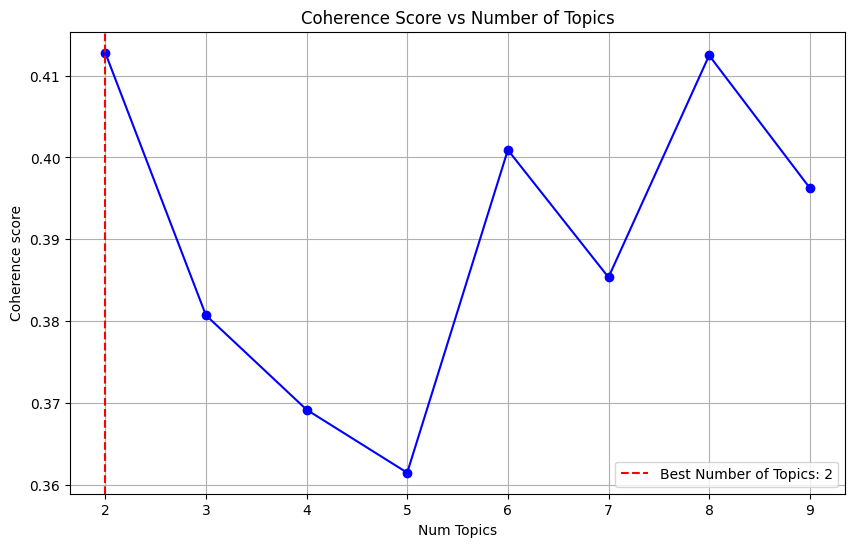

In [53]:
# تعداد موضوع‌های مورد نظر برای ارزیابی
num_topics = range(2, 10)  # مثلا از 2 تا 9 موضوع

# ذخیره‌ی مقادیر coherence برای هر تعداد موضوع
coherence_values = []

for num in num_topics:
    # Evaluate
    topics_for_eval = topic_words[:num]
    coherence_model = CoherenceModel(topics=topics_for_eval,
                                    texts=tokens,
                                    corpus=corpus,
                                    dictionary=dictionary,
                                    coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherence_values.append(coherence)

print(coherence_values)

# پیدا کردن مقدار بالاترین coherence و مکان آن
max_coherence = max(coherence_values)
best_num_topics = num_topics[coherence_values.index(max_coherence)]

# رسم نمودار coherence بر حسب تعداد موضوع
plt.figure(figsize=(10, 6))
plt.plot(num_topics, coherence_values, marker='o', color='b', linestyle='-')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Score vs Number of Topics")
plt.grid(True)

# رسم خط قرمز برای بالاترین نقطه coherence تا محور افقی
plt.axvline(x=best_num_topics, color='r', linestyle='--', label=f'Best Number of Topics: {best_num_topics}')
plt.legend()

plt.show()

In [54]:
# Print the coherence scores
for m, cv in zip(num_topics, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4128
Num Topics = 3  has Coherence Value of 0.3807
Num Topics = 4  has Coherence Value of 0.3692
Num Topics = 5  has Coherence Value of 0.3614
Num Topics = 6  has Coherence Value of 0.4009
Num Topics = 7  has Coherence Value of 0.3853
Num Topics = 8  has Coherence Value of 0.4125
Num Topics = 9  has Coherence Value of 0.3963


In [55]:
## Two Way
# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                            texts=tokens,
                            corpus=corpus,
                            dictionary=dictionary,
                            coherence="u_mass")
coherence = coherence_model.get_coherence()
print(coherence)

-9.748602220195822


[-11.760338800177514, -10.067224802148862, -10.199156403299892, -10.60127538480607, -9.18858557233777, -9.779611254192924, -8.833237914822968, -8.408111284942867]


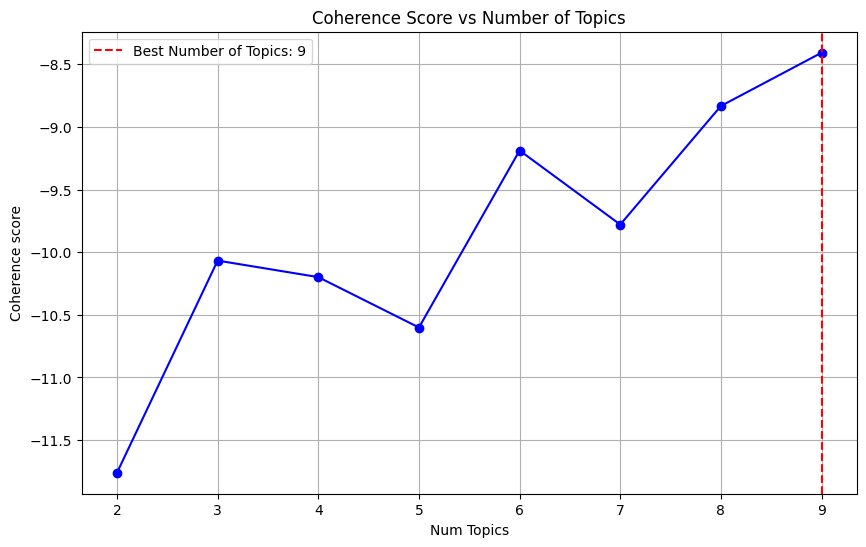

In [56]:
# تعداد موضوع‌های مورد نظر برای ارزیابی
num_topics = range(2, 10)  # مثلا از 2 تا 9 موضوع

# ذخیره‌ی مقادیر coherence برای هر تعداد موضوع
coherence_values = []

for num in num_topics:
    # Evaluate
    topics_for_eval = topic_words[:num]
    coherence_model = CoherenceModel(topics=topics_for_eval,
                                    texts=tokens,
                                    corpus=corpus,
                                    dictionary=dictionary,
                                    coherence='u_mass')
    coherence = coherence_model.get_coherence()
    coherence_values.append(coherence)

print(coherence_values)

# پیدا کردن مقدار بالاترین coherence و مکان آن
max_coherence = max(coherence_values)
best_num_topics = num_topics[coherence_values.index(max_coherence)]

# رسم نمودار coherence بر حسب تعداد موضوع
plt.figure(figsize=(10, 6))
plt.plot(num_topics, coherence_values, marker='o', color='b', linestyle='-')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Score vs Number of Topics")
plt.grid(True)

# رسم خط قرمز برای بالاترین نقطه coherence تا محور افقی
plt.axvline(x=best_num_topics, color='r', linestyle='--', label=f'Best Number of Topics: {best_num_topics}')
plt.legend()

plt.show()

In [57]:
# استفاده از تابع بالا برای تولید DataFrame از نتایج
df_topic_sents_keywords = format_bertopic_sentences(topic_model, documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# افزودن ستون‌های جدید به DataFrame اصلی با استفاده از pd.concat()
df_dominant_topic = pd.concat([df_dominant_topic, df[['Title', 'Authors', 'Source Title', 'Year']]], axis=1)
# نمایش DataFrame اصلی
print(df_dominant_topic.head(10))

2024-12-02 14:31:16,587 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2024-12-02 14:31:44,299 - BERTopic - Embedding - Completed ✓
2024-12-02 14:31:44,302 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-02 14:31:44,798 - BERTopic - Dimensionality - Completed ✓
2024-12-02 14:31:44,800 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-02 14:31:44,817 - BERTopic - Cluster - Completed ✓
2024-12-02 14:31:44,823 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-02 14:31:45,169 - BERTopic - Representation - Completed ✓


2
<class 'int'>
1
<class 'int'>
2
<class 'int'>
0
<class 'int'>
2
<class 'int'>
0
<class 'int'>
2
<class 'int'>
1
<class 'int'>
0
<class 'int'>
0
<class 'int'>
0
<class 'int'>
0
<class 'int'>
2
<class 'int'>
0
<class 'int'>
2
<class 'int'>
0
<class 'int'>
0
<class 'int'>
0
<class 'int'>
0
<class 'int'>
3
<class 'int'>
-1
<class 'int'>
0
<class 'int'>
2
<class 'int'>
-1
<class 'int'>
3
<class 'int'>
0
<class 'int'>
0
<class 'int'>
1
<class 'int'>
1
<class 'int'>
0
<class 'int'>
0
<class 'int'>
-1
<class 'int'>
0
<class 'int'>
4
<class 'int'>
0
<class 'int'>
0
<class 'int'>
0
<class 'int'>
3
<class 'int'>
3
<class 'int'>
0
<class 'int'>
0
<class 'int'>
1
<class 'int'>
0
<class 'int'>
0
<class 'int'>
0
<class 'int'>
0
<class 'int'>
0
<class 'int'>
0
<class 'int'>
0
<class 'int'>
3
<class 'int'>
1
<class 'int'>
2
<class 'int'>
3
<class 'int'>
0
<class 'int'>
-1
<class 'int'>
0
<class 'int'>
1
<class 'int'>
0
<class 'int'>
0
<class 'int'>
3
<class 'int'>
0
<class 'int'>
0
<class 'int'>
1
<c

In [58]:
## Save file BERT_topic.csv
df_dominant_topic.to_csv('BERT_topic.csv')

In [59]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# topic_num_keywords = {'Topic_Num': pd.Series([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])}
topic_num_keywords = {'Topic_Num': pd.Series(range(len(topic_counts)-1))}
topic_num_keywords = pd.DataFrame(topic_num_keywords)
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts,
                                topic_contribution], axis=1)
df_dominant_topics.reset_index(drop=True, inplace=True)
df_dominant_topics.columns = ['Dominant Topic', 'Num_Document', 'Perc_Document']
df_dominant_topics

,Dominant Topic,Num_Document,Perc_Document
0,0.0,171,0.5856
1,1.0,46,0.1575
2,2.0,28,0.0959
3,3.0,21,0.0719
4,4.0,11,0.0377
5,NaN,15,0.0514


In [60]:
df_dominant_topics.to_csv('BERT_distrbute.csv')

In [61]:
dlabel=df_dominant_topic.groupby("Dominant_Topic")['Year'].value_counts()
dlabel.head(10)

Dominant_Topic  Year  
-1.0            2023.0     6
                2021.0     3
                2022.0     2
                2019.0     1
                2024.0     1
 0.0            2023.0    69
                2022.0    37
                2021.0    18
                2020.0     9
                2019.0     6
Name: count, dtype: int64

In [62]:
df1 = pd.DataFrame(dlabel)
df1.to_csv('dominant_year.csv')

In [63]:
Data_year = pd.read_csv("dominant_year.csv",encoding='latin-1')
Data_year.head()

,Dominant_Topic,Year,count
0,-1.0,2023.0,6
1,-1.0,2021.0,3
2,-1.0,2022.0,2
3,-1.0,2019.0,1
4,-1.0,2024.0,1


In [64]:
# گرفتن مقادیر ستون Year
years = Data_year['Year'].tolist()
print("Years:", years)
# print(len(years))

# گرفتن مقادیر ستون count
counts = Data_year['count'].tolist()
print("Counts:", counts)
# print(len(counts))

Years: [2023.0, 2021.0, 2022.0, 2019.0, 2024.0, 2023.0, 2022.0, 2021.0, 2020.0, 2019.0, 2024.0, 2016.0, 2005.0, 2009.0, 2023.0, 2022.0, 2021.0, 2019.0, 2024.0, 2008.0, 2017.0, 2023.0, 2022.0, 2020.0, 2017.0, 2019.0, 2023.0, 2021.0, 2022.0, 2019.0, 2020.0, 2024.0, 2023.0, 2022.0, 2020.0, 2021.0]
Counts: [6, 3, 2, 1, 1, 69, 37, 18, 9, 6, 6, 2, 1, 1, 20, 8, 5, 3, 2, 1, 1, 15, 6, 2, 1, 1, 7, 4, 4, 1, 1, 1, 5, 2, 1, 1]


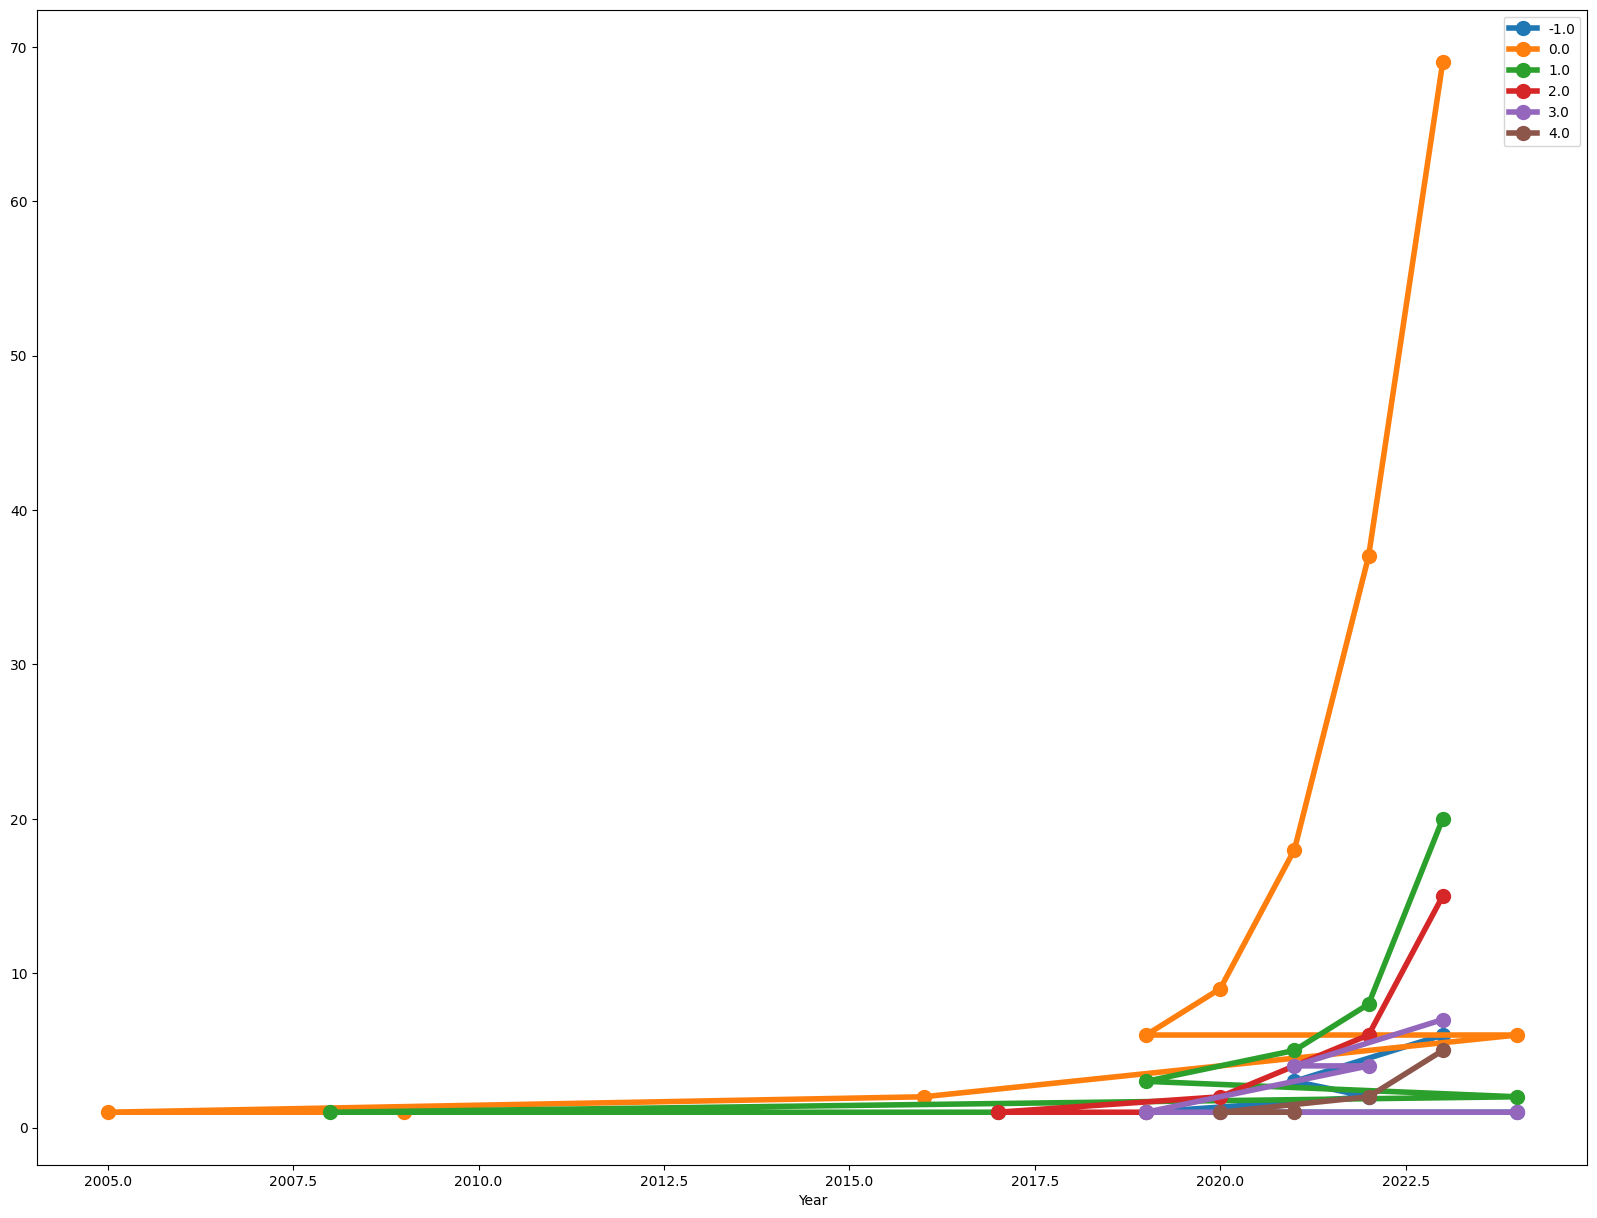

In [65]:
fig, ax = plt.subplots(figsize=(20,15))

for name, group in Data_year.groupby('Dominant_Topic'):
    group.plot(x='Year', y='count', ax=ax, label=name, marker='o',linewidth='4',markersize='10')

plt.show()

Topics extracted:  {-1: [('artificial intelligence', 0.020184306707261113), ('machine learning', 0.018006161252518107), ('deep learning', 0.014659318791805239), ('inclusive finance', 0.012139018674560836), ('rural inclusive', 0.012139018674560836), ('rural inclusive finance', 0.012139018674560836), ('covid19 pandemic', 0.011762034537406466), ('vaccine production', 0.010618123027909501), ('shipment time', 0.010618123027909501), ('learning technology', 0.009177846023359193)], 0: [('machine learning', 0.021883866689465882), ('artificial intelligence', 0.014864862932888268), ('deep learning', 0.010821233182440857), ('demand forecasting', 0.008868555986900482), ('neural network', 0.008156670485970031), ('learning technique', 0.00496835440234163), ('learning algorithm', 0.004683443288163548), ('literature review', 0.004161276602168511), ('machine learning technique', 0.004118876460652071), ('machine learning algorithm', 0.0036713496787447114)], 1: [('artificial intelligence', 0.0250108602625

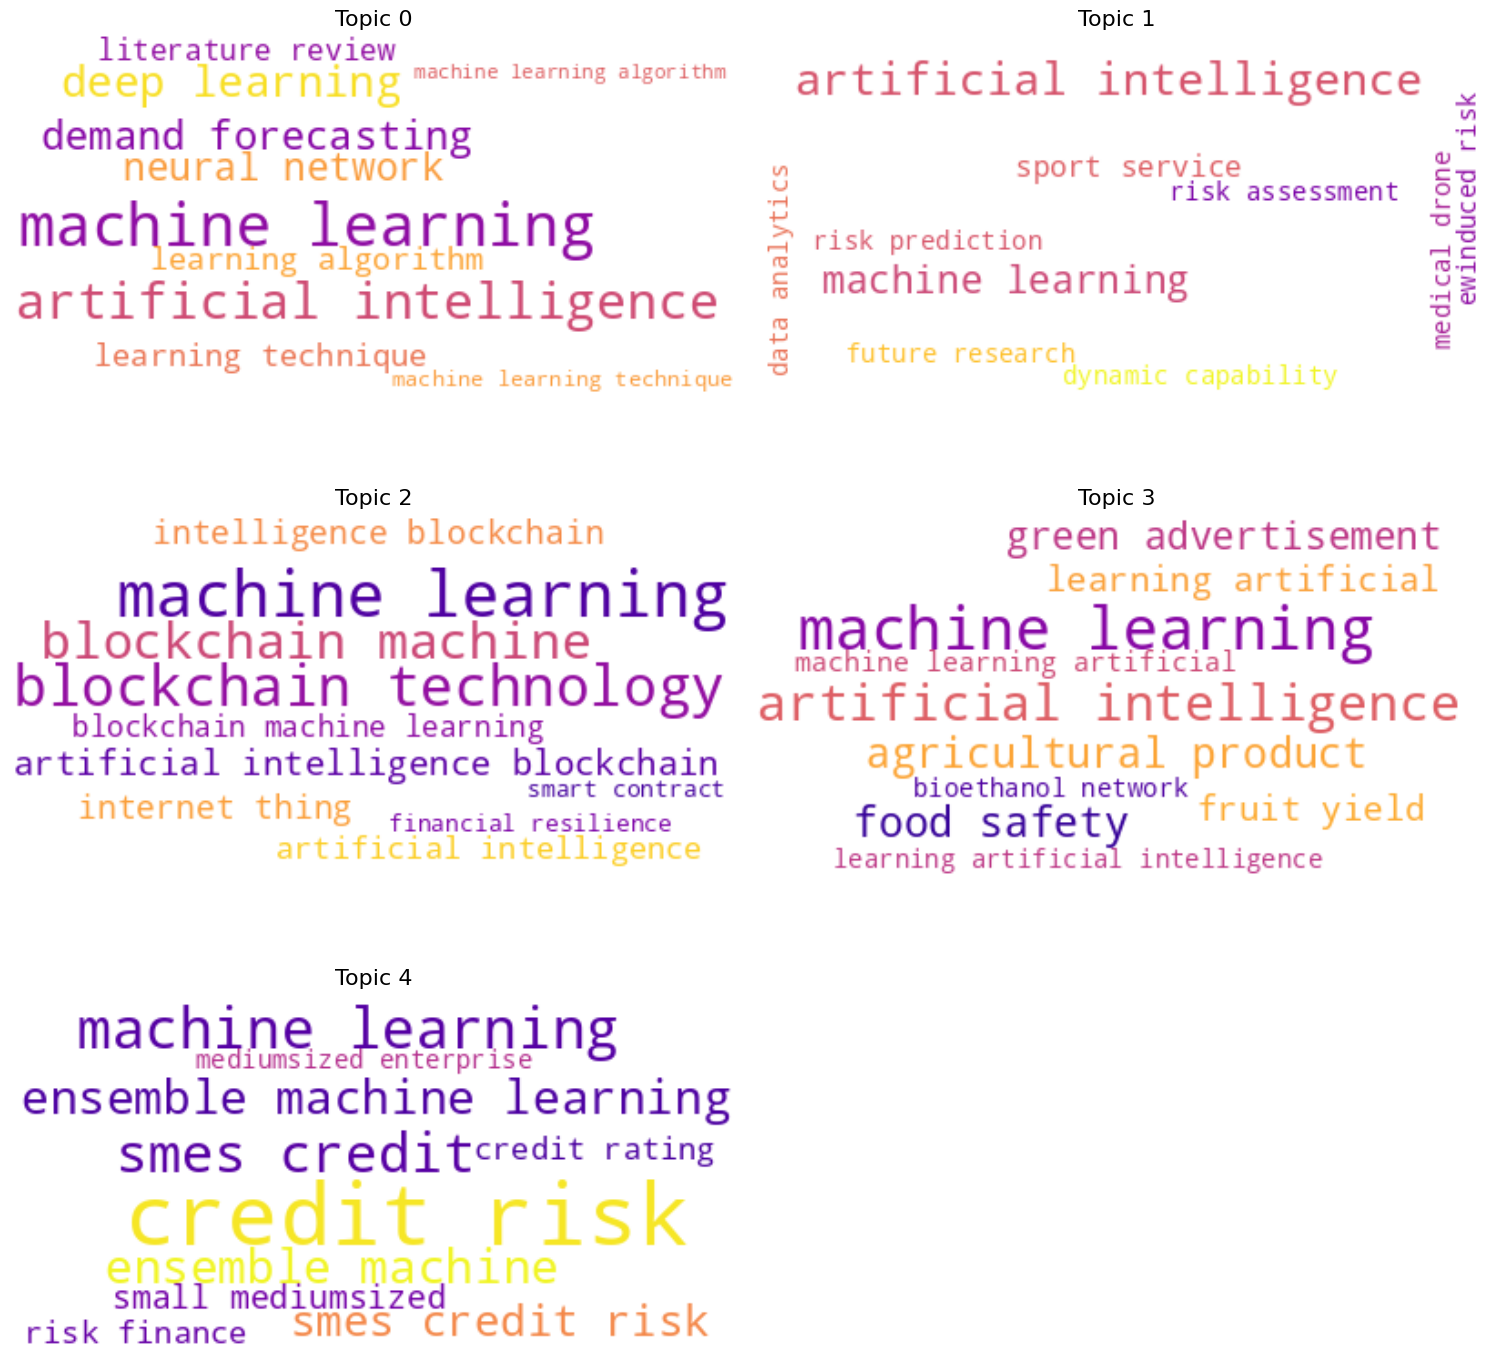

In [66]:
def plot_wordclouds(topic_model, num_topics=3):
   # استخراج کلمات کلیدی برای هر موضوع
    topics = topic_model.get_topics()
    print("Topics extracted: ", topics)

    # اطمینان از اینکه موضوعات به درستی استخراج شده‌اند
    if not topics:
        raise ValueError("No topics were extracted by BERTopic model.")

    # تنظیم تعداد ردیف‌ها و ستون‌های نمودار براساس تعداد موضوعات
    rows = (num_topics // 2) + (num_topics % 2)  # تنظیم تعداد ردیف‌ها به صورت دینامیک
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows), sharex=True, sharey=True)

    axes = axes.flatten()  # تبدیل ساختار ساب‌پلات‌ها به یک آرایه یک بعدی

    for i in range(num_topics):
        if i >= len(axes):  # اطمینان از عدم ارجاع به اندیس‌های بیشتر از تعداد ساب‌پلات‌ها
            break

        ax = axes[i]
        fig.add_subplot(ax)
        wc = WordCloud(max_words=50,
                       background_color='white',
                       stopwords=set(),
                       colormap='plasma')

        # استخراج کلمات کلیدی برای هر موضوع
        topic_words = topic_model.get_topic(i)
        if topic_words is None or isinstance(topic_words, bool):
            continue

        try:
            topic_words_dict = {word: weight for word, weight in topic_words}
        except TypeError as e:
            print(f"Error processing topic {i}: {e}")
            continue

        print(f"Topic {i}: {topic_words_dict}")

        wc.generate_from_frequencies(topic_words_dict)
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title('Topic ' + str(i), fontdict=dict(size=16))
        ax.axis('off')

    # حذف ساب‌پلات‌های اضافی
    for j in range(num_topics, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

# استفاده از تابع برای رسم نمودار کلمات
plot_wordclouds(topic_model, len(topic_counts)-1)